# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you):
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.

    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector

    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)] #if the maximum is 20, we have a sequence of length 20
        #so that number 3 will be [0,0,1,0,...,0] and so on.
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers

    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq] #in argmax we take the index, so we restore the original number


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.

    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1] #here we reverse the sequence

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)

    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a dataset of reversed pairs X, y.

    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """

    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze() #we remove dimensions=1.
    X_train = pairs[:,0]
    y_train = pairs[:,1]

    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset

    :model: Model to be fit
    :X_train, y_train: Train samples and labels
    :X_test y_test: Test samples and labels
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch2
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the training process.
    """

    # Train the model
    history=model.fit(X_train, y_train,
                      validation_split= 0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)

    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))

    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()


def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [ ]:
#Just an example to check the functions and the output
a=generate_sequence(5, 4)
o=one_hot_encode(a, 4)
print(o)

[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]]


In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):

    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    states = [encoder_state_h, encoder_state_c] #we have all the context vectors and the hidden states produced for each input.

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))

    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h

    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to
        # Concatenate the input + context vector to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(decoder_outputs)

        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)

        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis,
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



In [15]:
# dataset
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 6s 303ms/step - loss: 1.9473 - accuracy: 0.3195 - val_loss: 1.9685 - val_accuracy: 0.3066
Epoch 2/150
18/18 [==============================] - 5s 256ms/step - loss: 1.8974 - accuracy: 0.3287 - val_loss: 1.8140 - val_accuracy: 0.3502
Epoch 3/150
18/18 [==============================] - 5s 267ms/step - loss: 1.8348 - accuracy: 0.3432 - val_loss: 1.7590 - val_accuracy: 0.3629
Epoch 4/150
18/18 [==============================] - 5s 256ms/step - loss: 1.8038 - accuracy: 0.3482 - val_loss: 1.7642 - val_accuracy: 0.3564
Epoch 5/150
18/18 [==============================] - 5s 264ms/step - loss: 1.8218 - accuracy: 0.3409 - val_loss: 1.8524 - val_accuracy: 0.3350
Epoch 6/150
18/18 [==============================] - 5s 260ms/step - loss: 1.7319 - accuracy: 0.3654 - val_loss: 1.7542 - val_accuracy: 0.3608
Epoch 7/150
18/18 [==============================] - 5s 263ms/step - loss: 1.6792 - accuracy: 0.3810 - val_loss: 1.8101 - val_accuracy: 0.3330

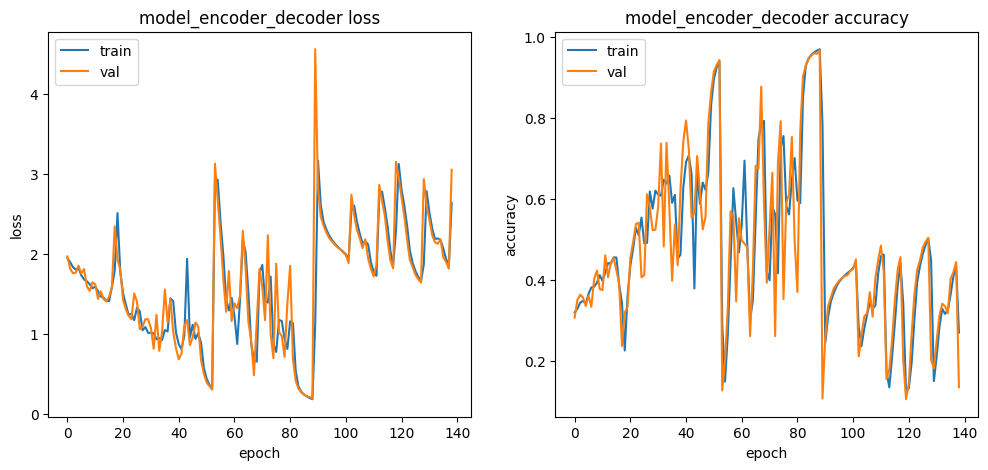

In [17]:
#training
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=100, epochs=150, patience=50)

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization.


Here we define two different ways of computing the attention weights and the context vector. The idea is to change how to compute the similarity or the score between vectors. The main difference between these and the luong-dot is that we have a more complex architecture due to training parameters (the matrix $W_a$ and the vector $v_a$).
In the next cell we will present attentions according to the following formulas:
$$ score(h_t,h_s)= h_t^TW_ah_s$$
and
$$ score(h_t,h_s)= v_a^T \tanh(W_a[h_t;h_s])$$
or equivalently
$$ score(h_t,h_s)= v_a^T \tanh(W_1h_t+W_2h_s).$$

In Bahdanau the gist is to capture a summary of both the preceding and succeeding words. A part from changing the score, context vectors and attention weights are computed in the same way.



In [4]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1) #we set the dimension of the output to 1 because we need a scalar
    #Here we initialize the matrix W_1,W_2 and V parameters of the attention.

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values))) #we compute the score according to the formula.

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

#Here we implement the luong general attention, we have one parameter which is the matrix W.

class LuongGeneralAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        self.W = tf.keras.layers.Dense(units)

    def call(self, query, values):
      query_with_time_axis = tf.expand_dims(query, 1)
      values_transposed = tf.transpose(values, perm=[0, 2, 1])

      # Luong multiplicative, we have a matrix W
      score = tf.transpose(tf.matmul(query_with_time_axis,
                                       self.W(values_transposed)), perm=[0, 2, 1])

      # attention_weights shape == (batch_size, max_length, 1)
      attention_weights = tf.nn.softmax(score, axis=1)

      context_vector = attention_weights * values
      context_vector = tf.reduce_sum(context_vector, axis=1)

      return context_vector, attention_weights




Now that we have defined three different attention, we are ready to compare the results. We will use the same hyperparamters and then compare the results. The first model evaluation is performed above, here we perform the model for the remaining two attentions

In [5]:
# attention model of bahdanau
attention_b = BahdanauAttention(rnn_units)
model_b_attention, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(attention_b, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 195s 3s/step - loss: 2.9657 - accuracy: 0.0539 - val_loss: 2.9470 - val_accuracy: 0.0575
Epoch 2/150
18/18 [==============================] - 14s 775ms/step - loss: 2.9454 - accuracy: 0.0548 - val_loss: 2.9445 - val_accuracy: 0.0529
Epoch 3/150
18/18 [==============================] - 14s 770ms/step - loss: 2.9430 - accuracy: 0.0596 - val_loss: 2.9405 - val_accuracy: 0.0602
Epoch 4/150
18/18 [==============================] - 14s 775ms/step - loss: 2.9392 - accuracy: 0.0643 - val_loss: 2.9355 - val_accuracy: 0.0683
Epoch 5/150
18/18 [==============================] - 14s 766ms/step - loss: 2.9292 - accuracy: 0.0756 - val_loss: 2.9236 - val_accuracy: 0.0789
Epoch 6/150
18/18 [==============================] - 14s 770ms/step - loss: 2.9177 - accuracy: 0.0814 - val_loss: 2.9138 - val_accuracy: 0.0850
Epoch 7/150
18/18 [==============================] - 14s 774ms/step - loss: 2.9075 - accuracy: 0.0873 - val_loss: 2.9034 - val_accuracy: 0

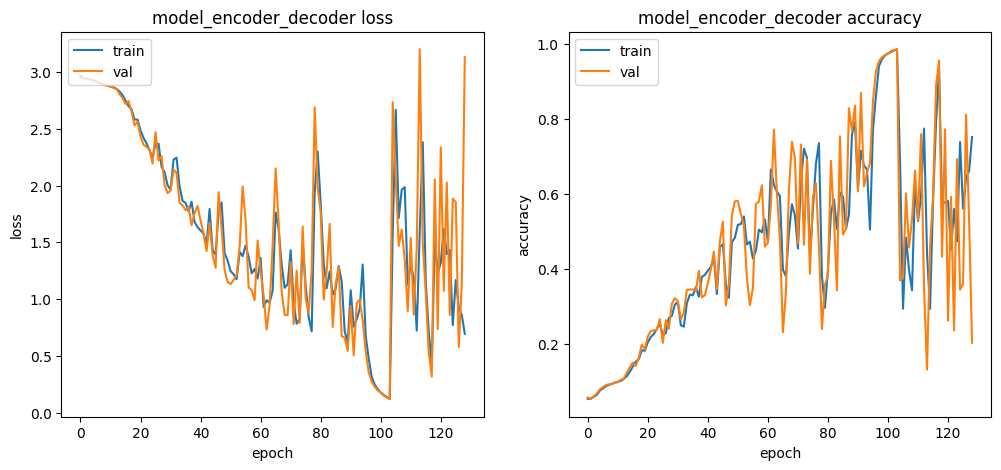

In [6]:
train_test(model_b_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=25)

In [12]:
#We use the same hyperparameters
# attention model
rnn_units=100
attention_g = LuongGeneralAttention(rnn_units)
model_g_attention, encoder_lstm_g, decoder_lstm_g, decoder_dense_g = build_attention_model(attention_g, batch_size, rnn_units)

Epoch 1/150
18/18 [==============================] - 187s 3s/step - loss: 2.9638 - accuracy: 0.0536 - val_loss: 2.9480 - val_accuracy: 0.0561
Epoch 2/150
18/18 [==============================] - 12s 644ms/step - loss: 2.9456 - accuracy: 0.0545 - val_loss: 2.9447 - val_accuracy: 0.0570
Epoch 3/150
18/18 [==============================] - 12s 644ms/step - loss: 2.9433 - accuracy: 0.0594 - val_loss: 2.9418 - val_accuracy: 0.0563
Epoch 4/150
18/18 [==============================] - 12s 645ms/step - loss: 2.9412 - accuracy: 0.0622 - val_loss: 2.9396 - val_accuracy: 0.0649
Epoch 5/150
18/18 [==============================] - 12s 646ms/step - loss: 2.9359 - accuracy: 0.0708 - val_loss: 2.9340 - val_accuracy: 0.0720
Epoch 6/150
18/18 [==============================] - 12s 645ms/step - loss: 2.9303 - accuracy: 0.0743 - val_loss: 2.9250 - val_accuracy: 0.0793
Epoch 7/150
18/18 [==============================] - 12s 657ms/step - loss: 2.9201 - accuracy: 0.0788 - val_loss: 2.9155 - val_accuracy: 0

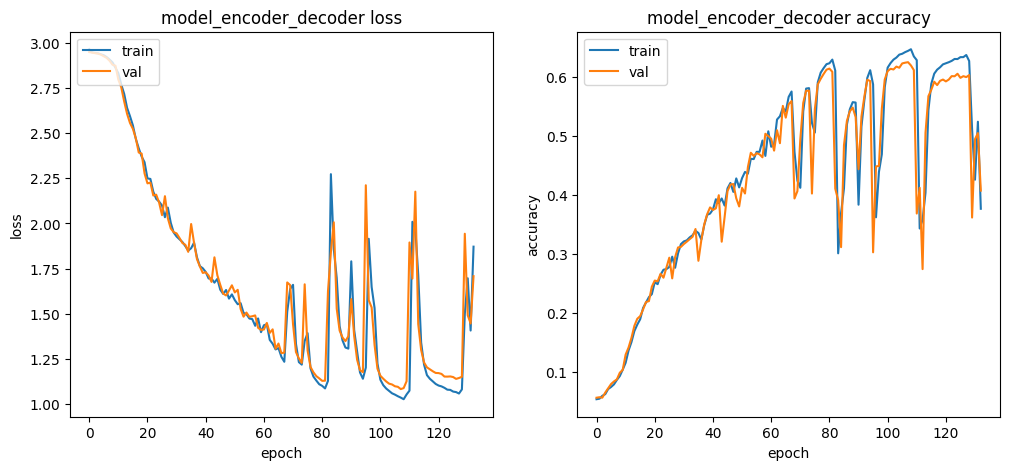

In [13]:
train_test(model_g_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=150, patience=25)

### Comparison between models ###

We trained all the three models with the same hyperparameters: rnn_units=100, number of epochs= 150 and batch_size=100. From the three graph we can see that after the training the original attention has a very good performance (even though when I re-runned the code I get a different accuracy and more instability while the original code showed a better stability after around 100 iterations). The BahdanauAttention performs the best while the multiplicative attention shows the worst performance. On the other hand the computational of these two models time is bigger than the original attention as they introduce parameters that increases the complexity of the architecture.

In [37]:
from prettytable import PrettyTable

table= PrettyTable()

table.field_names = ["Attention Model", "Accuracy", "Time/step"]

table.add_row(["LuongDot", 97.08 , "5s"], divider=True)
table.add_row(["BahdanauAttention", 98.48, "14s"], divider=True)
table.add_row(["LuongGeneral", 62.25 , "12s"], divider=True)

print(table)

+-------------------+----------+-----------+
|  Attention Model  | Accuracy | Time/step |
+-------------------+----------+-----------+
|      LuongDot     |  97.08   |     5s    |
+-------------------+----------+-----------+
| BahdanauAttention |  98.48   |    14s    |
+-------------------+----------+-----------+
|    LuongGeneral   |  62.25   |    12s    |
+-------------------+----------+-----------+


### Visualization of attention weights ###

To conclude the project we are going to visualize the attention weights for one example. In this way given a task (in our case to reserve the sentence) we want to check at each step if the attention is properly computed. In other words, since we are reversing, we expect that the first word input is highly correlated to the last word output and so on. In this scenario, then, attention weights should have a anti-diagonal form. The expectation is mostly fullfilled by all the three models considering their different level of accuracy. Indeed while the first two (Luongdot and BahdanauAttention) exhibit the desired pattern, the LuongGeneral, according also to a lower accuracy, shows a not so defined pattern.

In [8]:
def attention_prediction(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention):
  #We set attention plot to zero and then enconde input sequence
  #np.zeros of the length of our sequence of course. SO we want something 100x100 in our case
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(input_sequence,n_features)

  #There is no itialization since we already have them. ENCODER STEP
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs) #memorize the outputs from the LSTM model

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1
  inputs = decoder_input_data
  
  # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
  decoder_outputs = encoder_state_h


  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      #Here we save the attention weights in order to plot them after the function
      attention_weights = tf.reshape(attention_weights, (-1, )) #because we need a unidimensional vector so we reshape it
      attention_plot[t] = attention_weights.numpy() 

      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  output_sequence=one_hot_decode(decoder_outputs[0])

  return input_sequence, output_sequence, attention_plot

In [9]:
import seaborn as sns
import matplotlib.ticker as ticker


def plot_attention(attention, input_sequence, output_sequence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 10}
  #Here we use xticklabels and yticklabels to have as labels the entries of input sequence and outputsequence 
  
  ax.set_xticklabels([''] + input_sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output_sequence, fontdict=fontdict)

  #without this command the labels are not aligned properly and equally distributed with space 1.
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

#We are ready to finally visualize the attention plot. We obtain the output sequence and the attention plot from the previous function,
#then use the plot attention function to finally visualize the relationship between the input sequence and the output sequence.

def visualize(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention):
    input_sequence, output_sequence, attention_plot = attention_prediction(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention)
    attention_plot = attention_plot[:len(output_sequence), :len(input_sequence)]
    plot_attention(attention_plot, input_sequence, output_sequence)


#here it is another function to visualize attention weights in a different way:

def plot_attention_weights(attention_weights, input_sequence, output_sequence):
    plt.figure(figsize=(10, 6))
    sns.heatmap(attention_weights, cmap='viridis', annot=True, xticklabels=input_sequence, yticklabels=output_sequence)
    plt.title('Attention Weights')
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.show()




<ipython-input-9-3e1d6670f0ba>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sequence, fontdict=fontdict, rotation=90)
<ipython-input-9-3e1d6670f0ba>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_sequence, fontdict=fontdict)


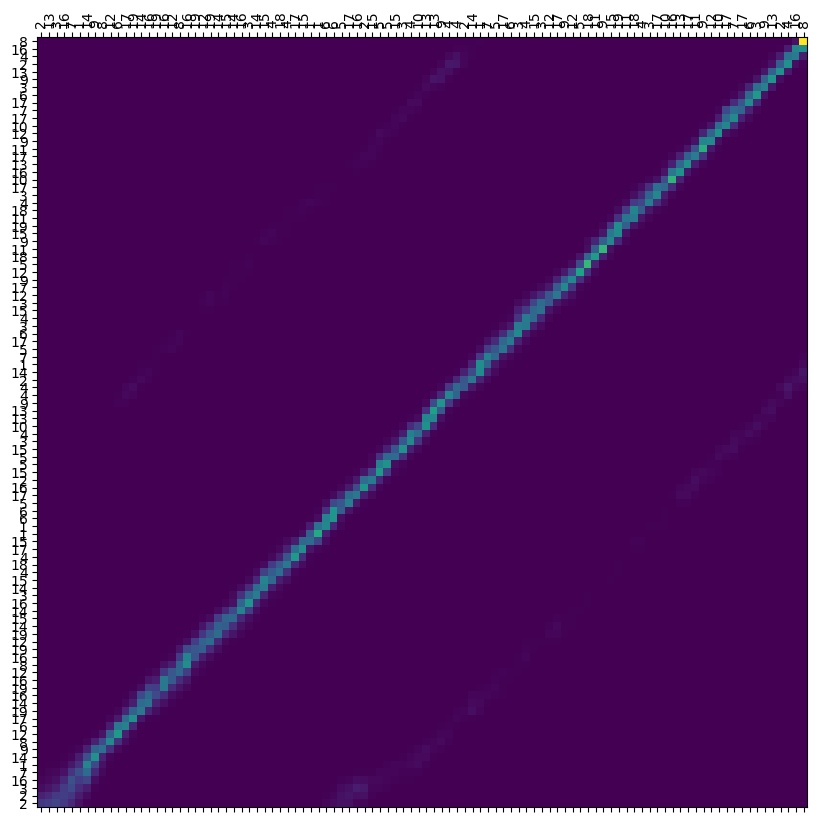

In [18]:
input_sequence=generate_sequence(n_timesteps_in,n_features)
visualize(input_sequence, encoder_lstm, decoder_lstm, decoder_dense, attention)


Now let's us visualize for the other two attention models

<ipython-input-9-3e1d6670f0ba>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sequence, fontdict=fontdict, rotation=90)
<ipython-input-9-3e1d6670f0ba>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_sequence, fontdict=fontdict)


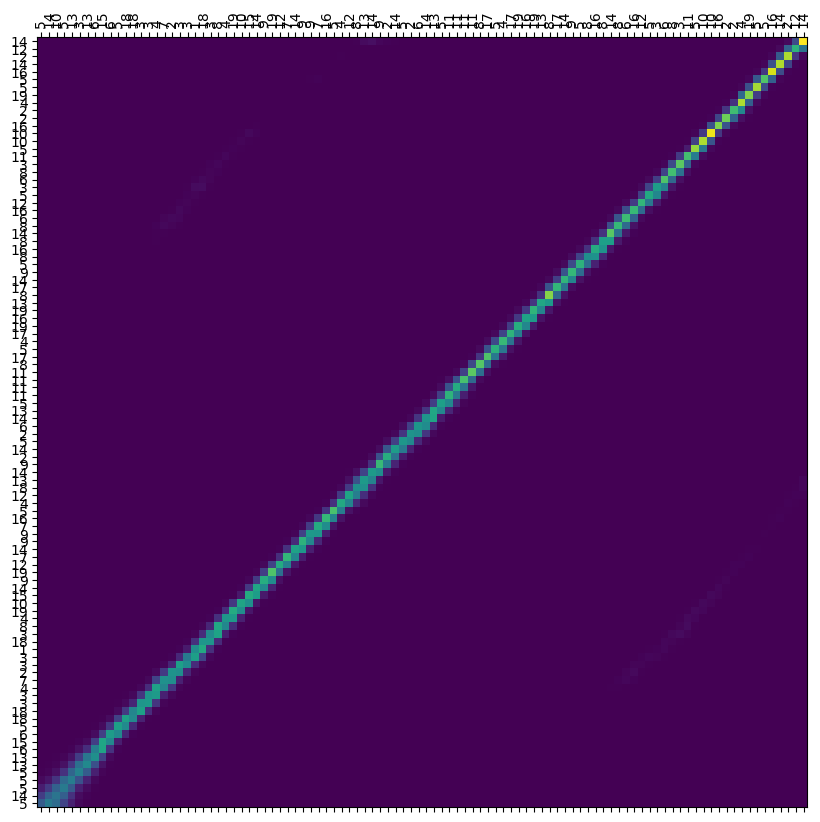

In [11]:
input_sequence=generate_sequence(n_timesteps_in,n_features)
visualize(input_sequence,  encoder_lstm_b, decoder_lstm_b, decoder_dense_b, attention_b)

<ipython-input-9-3e1d6670f0ba>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sequence, fontdict=fontdict, rotation=90)
<ipython-input-9-3e1d6670f0ba>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_sequence, fontdict=fontdict)


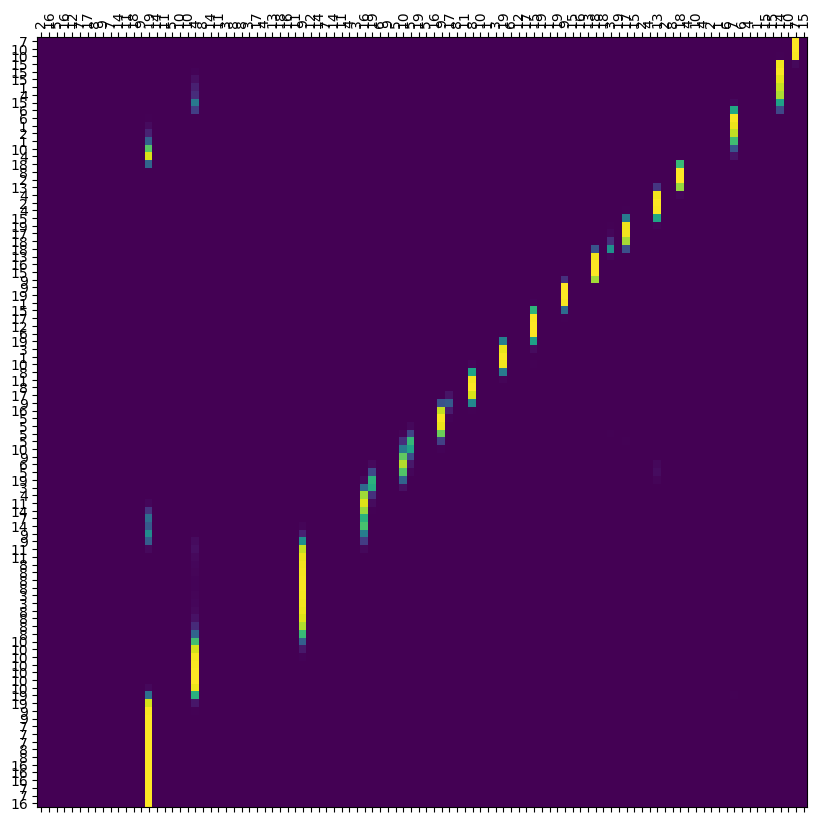

In [14]:
input_sequence=generate_sequence(n_timesteps_in,n_features)
visualize(input_sequence,  encoder_lstm_g, decoder_lstm_g, decoder_dense_g, attention_g)